# Introduction to Portfolio Construction and Analysis with Python
EDHEC Business School  
https://www.coursera.org/learn/introduction-portfolio-construction-python

## Introducing Liabilities Hedging Portfolios (LHP)

- Institutional main concern is an unexpected increase in the present value of their liabilities
- Increase in PV of liabilities will lead to a decrease in the funding ratio which is bad news because it's going to lead to a decrease in the probability for the asset owner who meet their liabilities.
- LHP is also known as Goal Hedging Portfolios (GHP)
- LHP is an asset portfolio that behaves exactly like the liabilities that we are trying to immunize against or that we are trying to protect.
- The safe asset is the asset that is safe with respect to the investor and more precisely with respect to the specific goal of the investor.
- Safe portfolios are known as cashflow matching or duration matching bond portfolios that will take on the asset side to increase exactly in parallel to the increase of the liability value. 

In [1]:
import sys  
sys.path.append('../src') 
from edhec_risk_kit import *

import ipywidgets as widgets
from IPython.display import display
import pandas as pd
import edhec_risk_kit as erk

import matplotlib.pyplot as plt

DATA_FOLDER = '../data/'

%matplotlib inline

# %load_ext autoreload
# autoreload 2

## Short Rate vs Annualised

In [2]:
def inst_to_ann(r):
    """
    Converts short rate to annualised rate
    """
    return np.expm1(r)

def ann_to_inst(r):
    """
    Converts annualised to a short rate
    """
    return np.log1p(r)

In [3]:
inst_to_ann(2)

6.38905609893065

In [4]:
ann_to_inst(0.03)

0.0295588022415444

## Simulating Interest Rate Changes and Liability Hedging
### Implementing the Cox Ingersoll Ross Model for interest rates

We saw in the previous lab that when you look at your financial condition in terms of funding ratio, rather than asset value, even cash can be a risky asset.

We're going to simulate changes in interest rates using the Cox-Ingersoll-Ross model, usually just called the CIR model. It is very similar to what we have already done for generating random stock prices. Instead of a Geometric Brownian Motion, the mean reversion model features parameters to control the speed of mean reversion as well as the long term average rate.

$$ dr_{t}=a(b-r_{t})\,dt+\sigma {\sqrt  {r_{t}}}\,dW_{t} $$

where $a$ is the speed of mean reversion and $b$ is the long term mean rate and $\sigma$ is the volatility parameter.

This can be read as describing the change in interest at any point of time as a multiple of the distance of the current rate from it's long term mean plus a random value that depends on the volatility parameter.

Thus, we can start at some rate $r_0$ and generate a sequence of rates over time using the change in rate defined by the stochastic differential equation above. If we eliminate the ${\sqrt  {r_{t}}}$ term we get the simpler Vasicek model, but the CIR model eliminates the possibility of negative interest rates by shutting down the volatility term as interest rates approach zero. 

### Short Rate vs Annualized Rate

One final piece of math we'll need is that the interest rate being described here is the "instantaneous" or "short rate" ... we will often want to think about interest rates as annualized rates, which means that the instantaneous rate needs to be compounded into an annual rate as follows:

$$ 1 + r_{annual} = e^{r_{inst}} $$

### Quick Explanation of Short Rate vs Annual Rate

The distinction between the instantaneous rate and the annualized rate is subtle if you have never had an opportunity to think about it, but is best understood in terms of an example:

Let's consider the growth of a dollar over a year, if the rate of interest is 100%.

To answer the question about what that will grow to at the end of the year, we'll need to answer a second question, which is how often will that interest be paid?

If it's paid just once at the end of the year, the answer is easy. The dollar grows to 2 dollars (one dollar in principle and another dollar in interest).

In [5]:
def cir(n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Implements the CIR model for interest rates
    """
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0)
    
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year)+1
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        
    return pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))

Using CIR Model to simulate interest rate movements.  Note that rates on the plots are annualised short term rates.

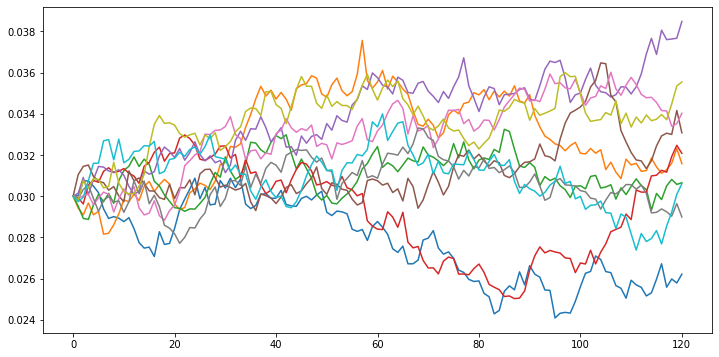

In [6]:
cir(n_scenarios=10, sigma=0.01).plot(figsize=(12,6), legend=False)
plt.show()

In [7]:
def show_cir(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios).plot(legend=False, figsize=(12,5))
    
import ipywidgets as widgets
from IPython.display import display

controls = widgets.interactive(show_cir,
                               r_0 = (0, .15, .01),
                               a = (0, 1, .1),
                               b = (0, 0.15, .01),
                               sigma = (0, .1, .01),
                               n_scenarios = (1,100))

display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

## Generating the random price evolution of a Zero-Coupon Bond

The model can also be used to generate the movement of bond prices for a zero coupon bond that are implied by the generated interest rate, using the following equations:

$$P(t,T)=A(t,T)e^{-B(t,T)r_{t}}\!$$

where

$$ A(t,T)=\left({\frac  {2h e^{(a+h)\tau/2}}{2h+(a+h)(e^{\tau h}-1)}}\right)^{{2ab/\sigma ^{2}}} $$
and
$$ B(t,T)={\frac  {2(e^{\tau h}-1)}{2h+(a+h)(e^{\tau h}-1)}} $$
and
$$ h={\sqrt  {a^{2}+2\sigma ^{2}}} $$
and
$$ \tau = T-t $$


In [8]:
import math

def cir(n_years = 10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Generate random interest rate evolution over time using the CIR model
    b and r_0 are assumed to be the annualized rates, not the short rate
    and the returned values are the annualized rates as well
    """
    if r_0 is None: r_0 = b 
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1 # because n_years might be a float
    
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0

    ## For Price Generation
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    ####

    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h + (h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    prices[0] = price(n_years, r_0)
    ####
    
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        # generate prices at time t as well ...
        prices[step] = price(n_years-step*dt, rates[step])

    rates = pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))
    ### for prices
    prices = pd.DataFrame(data=prices, index=range(num_steps))
    ###
    return rates, prices

In [9]:
def show_cir_prices(r_0=0.03, a=0.05, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[1].plot(legend=False, figsize=(12,5))
    
controls = widgets.interactive(show_cir_prices,
                               r_0 = (0, .15, .01),
                               a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma = (0, .1, .01),
                               n_scenarios = (1,100)
                               )

display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.05,…

## Liabilities Matching

Liability to match is a million dollars 10 years from now.
Current asset value is 750k

Note that putting money all in cash is not a safe hedge, because there's some realistic chance that you're simply not going to be able to make that $1 million liability.

Investing in zero coupon bond
Should look at funding ratio

In [10]:
# my starting asset value today aka cash in hand
a_0 = 0.75
# simulate the next 10 years
rates, bond_prices = erk.cir(r_0=0.03, b=0.03, n_scenarios=10)
# liabilities are going to change over time to match the payoff of the ZCB
liabilities = bond_prices
# today's zero coupon bond price is the present value of 1 dollar in 10 years
zc_0 = erk.pv_2(pd.Series(data=[1], index=[10]), 0.03)
# I can put my money in a zero coupon bond at today's price
n_bonds = a_0/zc_0
# and my asset value will grow based on the bond prices
av_zc_bonds = n_bonds*bond_prices
# how about if I invest in cash? It will grow at some rate of interest
av_cash = a_0*(rates/12+1).cumprod()

### Asset Value
- There is no certainty in asset terminal value when holding cash
- There is certainty in asset termina value when investing in zero coupon bonds

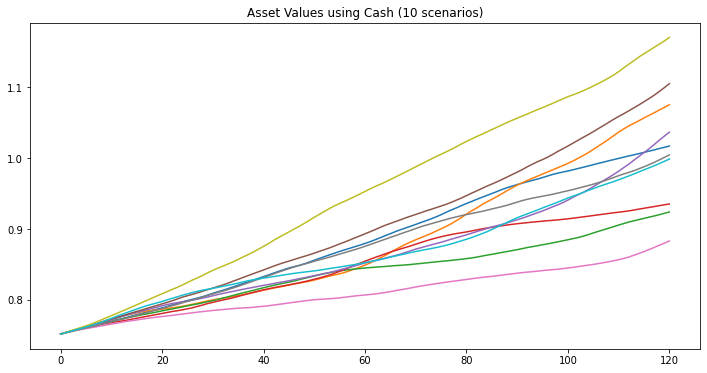

In [11]:
av_cash.plot(title='Asset Values using Cash (10 scenarios)', legend=False, figsize=(12,6))
plt.show()

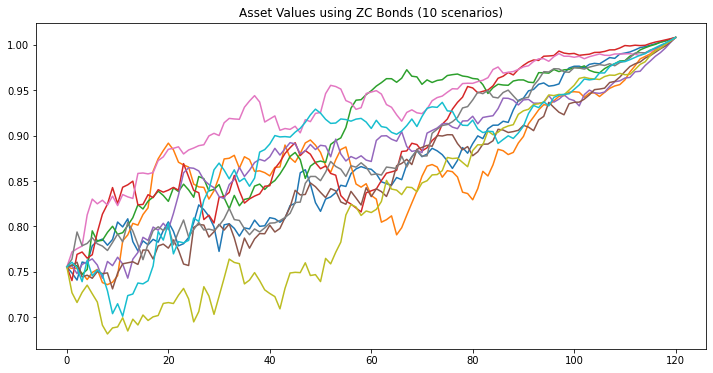

In [12]:
av_zc_bonds.plot(title='Asset Values using ZC Bonds (10 scenarios)', legend=False, figsize=(12,6))
plt.show()

### Returns of Asset Value
- Volatility of asset value across all periods is high when holding cash
- Volatility of asset value across all periods decreases when holding zero coupon bonds

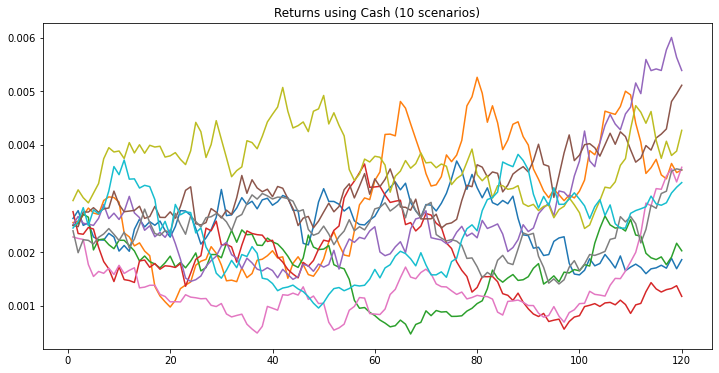

In [13]:
av_cash.pct_change().plot(title='Returns using Cash (10 scenarios)', legend=False, figsize=(12,6))
plt.show()

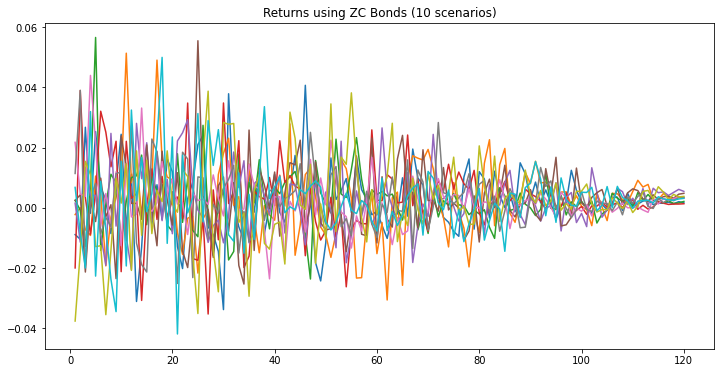

In [14]:
av_zc_bonds.pct_change().plot(title='Returns using ZC Bonds (10 scenarios)', legend=False, figsize=(12,6))
plt.show()

### Returns of Funding Ratios over time
- Returns and Volatility of Funding Ratios decrease over time when holding cash
- No changes and volatiltiy of Funding Ratio when invested in Zero Coupon Bonds because the liabilities are matched

In [15]:
a_0 = 0.75
rates, bond_prices = cir(n_scenarios=10, r_0=0.03, b=0.03)
liabilities = bond_prices
zcbond_10 = pd.Series(data=[1], index=[10])
zc_0 = erk.pv(zcbond_10, 0.03)
n_bonds = a_0/zc_0
av_zc_bonds = n_bonds*bond_prices
av_cash = a_0*(rates/12+1).cumprod()

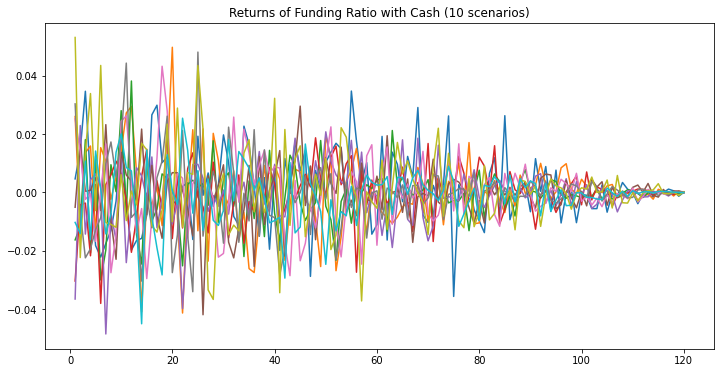

In [16]:
(av_cash/liabilities).pct_change().plot(title='Returns of Funding Ratio with Cash (10 scenarios)', 
                                        legend=False, figsize=(12,6))
plt.show()

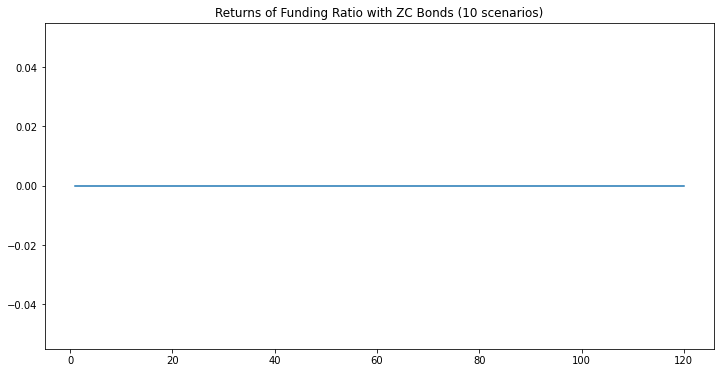

In [17]:
(av_zc_bonds/liabilities).pct_change().plot(title='Returns of Funding Ratio with ZC Bonds (10 scenarios)',
                                            legend=False, figsize=(12,6))
plt.show()

### Terminal Funding Ratios
- The funding ratios if invested in zero coupon bonds will be 1 for all scenarios.  This means you will be 100% funding your liabilities.
- Note that this is only possible of there is sufficient initial asset value
- While cash may be deemed to be a safe asset, you will observed that holding cash may not generate enough income to fund your liabilities.  There are scenarios with a funding ratio of less than 1 if holding cash.

In [18]:
a_0 = 0.75
rates, bond_prices = cir(n_scenarios=10000, r_0=0.03, b=0.03)
liabilities = bond_prices
zcbond_10 = pd.Series(data=[1], index=[10])
zc_0 = erk.pv(zcbond_10, 0.03)
n_bonds = a_0/zc_0
av_zc_bonds = n_bonds*bond_prices
av_cash = a_0*(rates/12+1).cumprod()

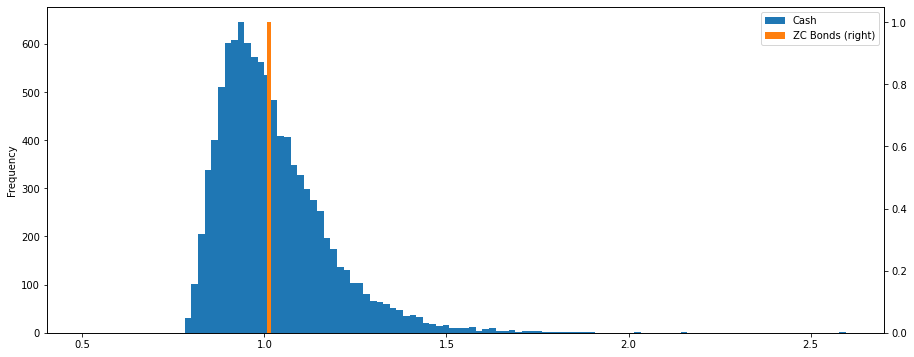

In [19]:
tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]
tfr_zc_bonds = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]
ax = tfr_cash.plot.hist(label="Cash", figsize=(15,6), bins=100, legend=True)
tfr_zc_bonds.plot.hist(ax=ax, label="ZC Bonds", bins=100, legend=True, secondary_y=True)
plt.show()

## Conclusion

As you can see, hedging a future liability with cash or even cash-like instruments can be very risky. Although Zero Coupon Bonds are nominally risky and can see a great deal of price fluctuation, they vary in price in tandem with the liabilities, resulting in a much better hedge.

Of course, this makes two convenient assumptions that are often not true in practice. First, it assumes that zero coupon bonds with the perfect maturities are always available, and second, it assumes that you have the intial assets to be able to afford the hedge.

We shall try and address these in future sections. We address the first by holding a portfolio of non zero coupon bonds that will behave like a zero coupon bond in the sense that it can be liquidated at a particular maturity for an amount that is immunized against changes in interest rates. We'll address the second issue by introducing a second building block to deliver the higher performance to try and close the gap between your current assets and the upside target.

---

## Extra notes

Discussion on using annualised and short rates

[Lab Session-CIR Model and cash vs ZC bonds](https://www.coursera.org/learn/introduction-portfolio-construction-python/discussions/weeks/4/threads/v6pHlhs4R_CqR5YbOJfwJw)

### Single-Period Compounding

In [20]:
N = 1
r = 0.03
t = 10
(1+r/N)**-(t*N)

0.7440939148967249

In [21]:
erk.pv(zcbond_10, 0.03).values[0]

0.7440939148967249

In [22]:
erk.pv_2(zcbond_10, 0.03)

0.7440939148967249

### Continous Compounding

In [23]:
r = 0.03
t = 10
np.exp(-r*t)

0.7408182206817179